# IMPORT LIBRARIES


In [1]:
!pip install contractions
!pip install xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 8.9 MB/s eta 0:00:00


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import re
import nltk
import contractions
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import kagglehub
import os
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import string
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification
from transformers import get_scheduler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from google.colab import drive
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import xgboost as xgb
import kagglehub

drive.mount('/content/drive')

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
punctuations = set(string.punctuation)
lemmatizer = WordNetLemmatizer()


Mounted at /content/drive


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# Read data

In [5]:

# Download latest version
path = kagglehub.dataset_download("nicapotato/womens-ecommerce-clothing-reviews")
print("Path to dataset files:", path)


100%|██████████| 2.79M/2.79M [00:00<00:00, 4.38MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nicapotato/womens-ecommerce-clothing-reviews/versions/1


In [6]:
file_path = os.path.join(path,"Womens Clothing E-Commerce Reviews.csv")
df = pd.read_csv(file_path, encoding="ISO-8859-1")
df['Department Name'].value_counts().head(6)

,count
Department Name,
Tops,10468
Dresses,6319
Bottoms,3799
Intimate,1735
Jackets,1032
Trend,119


# Plot

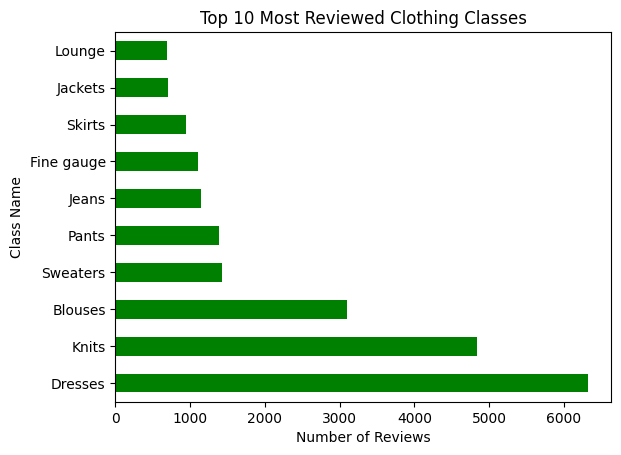

In [7]:

df['Class Name'].value_counts().head(10).plot(kind='barh', color='green')
plt.title('Top 10 Most Reviewed Clothing Classes')
plt.xlabel('Number of Reviews')
plt.show()


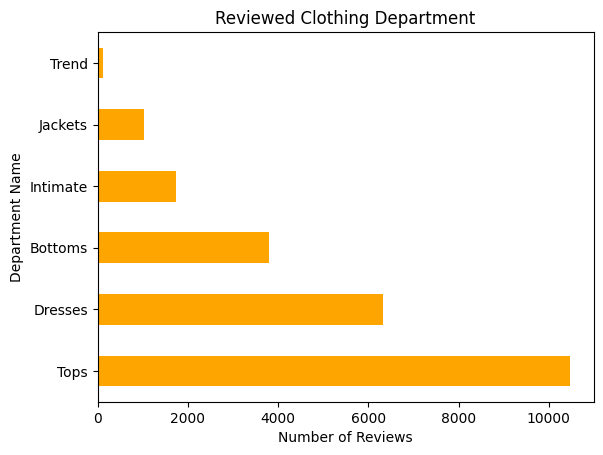

In [8]:

df['Department Name'].value_counts().head(10).plot(kind='barh', color='orange')
plt.title('Reviewed Clothing Department')
plt.xlabel('Number of Reviews')
plt.show()

# Clean Text


In [9]:
#boş yorumlar  ve eksik veriler silinir.
df.dropna(subset=['Review Text'], inplace=True)
df.dropna(subset=['Department Name'], inplace=True)
df = df[df['Review Text'].str.strip() != ""]


In [10]:
def get_wordnet_pos(tag):
     if tag.startswith('J'):
       return wordnet.ADJ
     elif tag.startswith('V'):
       return wordnet.VERB
     elif tag.startswith('N'):
       return wordnet.NOUN
     elif tag.startswith('R'):
       return wordnet.ADV
     else:
       return wordnet.NOUN

In [11]:
def clean_text(text):
     text = contractions.fix(text) #kısa kelimeleri açar don't->do not
     text = text.lower()
     # özel karakterleri temizler
     text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
     # birden fazla boşluğu tek bir boşlukla değiştirip baştaki ve sondaki boşlukları kaldırır
     text = re.sub(r'\s+', ' ', text).strip()
     words = word_tokenize(text) #cümleyi kelimelere ayırır
     words = [t for t in words if t not in stop_words and t not in punctuations and t.isalpha()]
     pos_tags = pos_tag(words)
     lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

     return " ".join(lemmatized)

df['Review Text'] = df['Review Text'].apply(clean_text)


In [12]:
df['Review Text'].head()

,Review Text
0,absolutely wonderful silky sexy comfortable
1,love dress sooo pretty happen find store glad ...
2,high hope dress really wanted work initially o...
3,love love love jumpsuit fun flirty fabulous ev...
4,shirt flatter due adjustable front tie perfect...


# LabelEncoder

In [13]:

#encode işlemi
label_encoder= LabelEncoder()
df['Department_encoded']=label_encoder.fit_transform(df['Department Name'])

df['Department_encoded'].head()


,Department_encoded
0,2
1,1
2,1
3,0
4,4


# Train-Test Split

In [14]:
X_train,X_test,y_train,y_test= train_test_split(df['Review Text'], df['Department_encoded'],test_size=0.2,random_state=42)

# BertTokenizer

In [15]:

tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_reviews(texts, tokenizer, max_len=256):
      return tokenizer(texts.tolist(),padding=True,truncation=True,max_length=max_len,return_tensors='pt')


train_encodings=tokenize_reviews(X_train, tokenizer)
test_encodings=tokenize_reviews(X_test,tokenizer)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

# Tensor Dataset

In [16]:

train_dataset=TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.tolist()))
test_dataset=TensorDataset(test_encodings['input_ids'],test_encodings['attention_mask'], torch.tensor(y_test.tolist()))


# Data Loader
batch

In [17]:
train_loader=DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader= DataLoader(test_dataset,batch_size=16, shuffle=True)

# Classification

In [18]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**device**

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**optimizer , lr_scheduler**

In [22]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
num_epochs = 6
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler(
     "linear",
     optimizer=optimizer,
     num_warmup_steps=0,
     num_training_steps=num_training_steps
)

# MODEL TRAINING

In [23]:
# MODEL TRAINING
model.train()
for epoch in range(num_epochs):
     print(f"Epoch {epoch+1}/{num_epochs}")
     total_loss = 0
     for batch in train_loader:
         input_ids, attention_mask, labels = [b.to(device) for b in batch]
         outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
         loss = outputs.loss
         total_loss += loss.item()
         loss.backward()
         optimizer.step()
         lr_scheduler.step()
         optimizer.zero_grad()
     print(f"Average loss: {total_loss / len(train_loader):.4f}")


Epoch 1/6
Average loss: 0.2565
Epoch 2/6
Average loss: 0.1841
Epoch 3/6
Average loss: 0.1268
Epoch 4/6
Average loss: 0.0872
Epoch 5/6
Average loss: 0.0581
Epoch 6/6
Average loss: 0.0411


#  MODEL EVALUATION

In [24]:
# MODEL EVALUATION
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
     for batch in test_loader:
         input_ids, attention_mask, labels = [b.to(device) for b in batch]
         outputs = model(input_ids=input_ids, attention_mask=attention_mask)
         logits = outputs.logits
         preds = torch.argmax(logits, dim=1)
         all_preds.extend(preds.cpu().numpy())
         all_labels.extend(labels.cpu().numpy())

# CLASSIFICATION REPORT

In [25]:

acc = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
print("Accuracy: ", acc)
print("F1 Score: ", f1)


Accuracy:  0.8574900574458684
F1 Score:  0.8518998447290124


In [26]:
unique_labels = sorted(np.unique(np.concatenate((all_labels, all_preds))))
target_names = [str(label_encoder.classes_[i]) for i in unique_labels]

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))



Classification Report:
              precision    recall  f1-score   support

     Bottoms       0.83      0.85      0.84       718
     Dresses       0.90      0.90      0.90      1260
    Intimate       0.67      0.49      0.56       316
     Jackets       0.71      0.63      0.67       211
        Tops       0.88      0.93      0.90      1998
       Trend       0.00      0.00      0.00        23

    accuracy                           0.86      4526
   macro avg       0.66      0.63      0.65      4526
weighted avg       0.85      0.86      0.85      4526



# Confusion Matrix

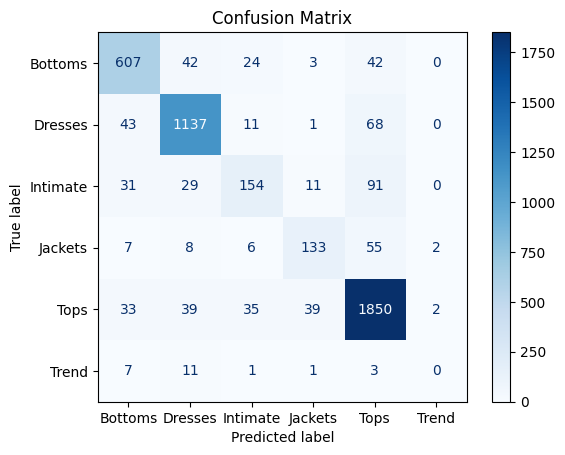

In [27]:

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Save Model

In [28]:
model_save_path = "/content/drive/MyDrive/bert_department_model.pt"
torch.save(model.state_dict(), model_save_path)
print("Model kaydedildi:", model_save_path)

Model kaydedildi: /content/drive/MyDrive/bert_department_model.pt



# XGBOOST



# TfidfVectorizer

In [29]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2)) # Unigram + Bigram kullanımı kelime çifti**
X_tfidf = vectorizer.fit_transform(df['Review Text'])

In [30]:
# Hedef değişken
y = df['Department_encoded']


# Train-Test Split

In [31]:
# eğitim ve test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf,y, test_size=0.2, random_state=42)


# XGBClassifier

In [32]:
xgb_model=xgb.XGBClassifier(
     n_estimators=300,
     learning_rate=0.1,
     max_depth=6,
     random_state=42,
     use_label_encoder=False,
     eval_metrics='mlogloss'
)

xgb_model.fit(X_train,y_train)

y_pred=xgb_model.predict(X_test)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:33:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "eval_metrics", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#  Classification report

In [33]:
print("Model Doğruluk Skoru:", accuracy_score(y_test, y_pred))
print("\nSınıflandırma Raporu:\n", classification_report(y_test, y_pred))

Model Doğruluk Skoru: 0.8362792752982766

Sınıflandırma Raporu:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82       718
           1       0.90      0.86      0.88      1260
           2       0.81      0.40      0.54       316
           3       0.74      0.60      0.66       211
           4       0.81      0.94      0.87      1998
           5       0.00      0.00      0.00        23

    accuracy                           0.84      4526
   macro avg       0.69      0.60      0.63      4526
weighted avg       0.83      0.84      0.83      4526



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# save model

In [ ]:
joblib.dump(xgb_model, "/content/drive/MyDrive/xgb_department_model.joblib")